# Integration of the data sources and EDA

In [1]:
import requests
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
%matplotlib inline
from jupyterthemes import jtplot
jtplot.style(theme='solarizedd')
plt.rcParams['figure.figsize'] = (20.0, 10.0)

import sys
sys.path.append('../src')

from data import world_bank as wb

In [2]:
END_DATE = 2017

cpi = wb.download_cpis(['uy', 'us'], end_date=END_DATE)
rate = wb.download_exchange_rate('uy', end_date=END_DATE)

In [3]:
print(cpi.shape)
print(rate.shape)

(58, 2)
(58, 1)


In [4]:
cpi.head()

,Uruguay,United States
1960,0.000004,13.563061
1961,0.000005,13.708284
1962,0.000005,13.872615
1963,0.000006,14.044590
1964,0.000009,14.224207


In [5]:
rate.head()

,Uruguay
1960,0.000011
1961,0.000011
1962,0.000011
1963,0.000015
1964,0.000016


In [6]:
data = cpi.join(rate.rename(columns={'Uruguay':'usd_uy'}))
data = data.rename(columns={'Uruguay': 'cpi_uy', 'United States': 'cpi_usa'})
print(data.shape)
data.head()

(58, 3)


,cpi_uy,cpi_usa,usd_uy
1960,0.000004,13.563061,0.000011
1961,0.000005,13.708284,0.000011
1962,0.000005,13.872615,0.000011
1963,0.000006,14.044590,0.000015
1964,0.000009,14.224207,0.000016


In [7]:
data['raw_q'] = data.cpi_uy / data.cpi_usa
data.head()

,cpi_uy,cpi_usa,usd_uy,raw_q
1960,0.000004,13.563061,0.000011,2.765001e-07
1961,0.000005,13.708284,0.000011,3.358009e-07
1962,0.000005,13.872615,0.000011,3.680164e-07
1963,0.000006,14.044590,0.000015,4.407730e-07
1964,0.000009,14.224207,0.000016,6.196018e-07


In [8]:
mean_coef = (data.usd_uy / data.raw_q).mean()
data['q_mean'] = mean_coef * data.raw_q

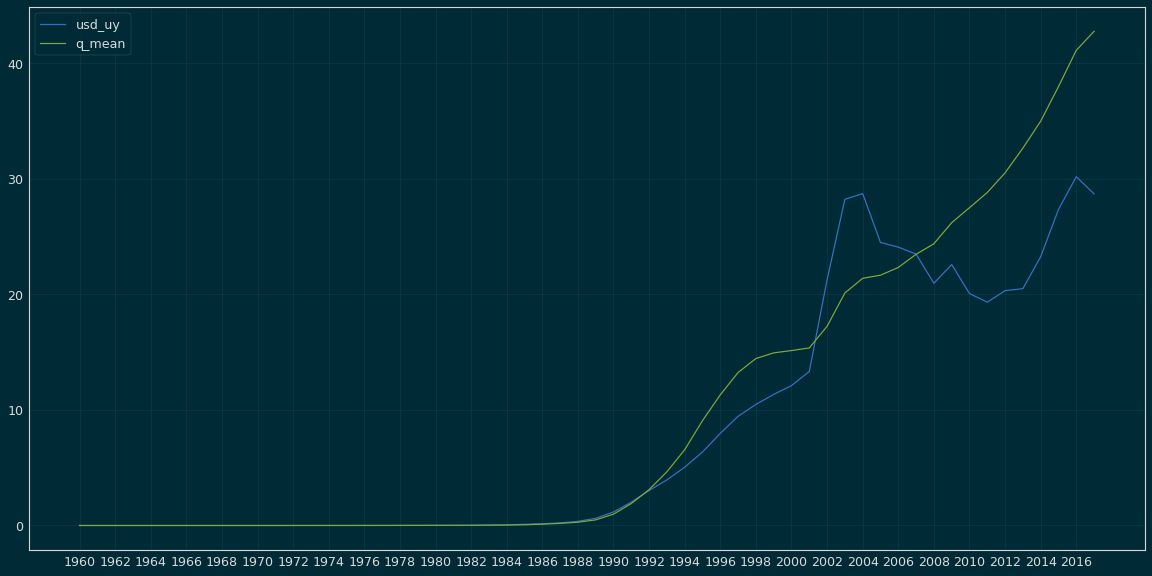

In [9]:
data[['usd_uy', 'q_mean']].plot(use_index=True)
_ = plt.xticks(np.arange(data.index.min(), data.index.max(), 2))

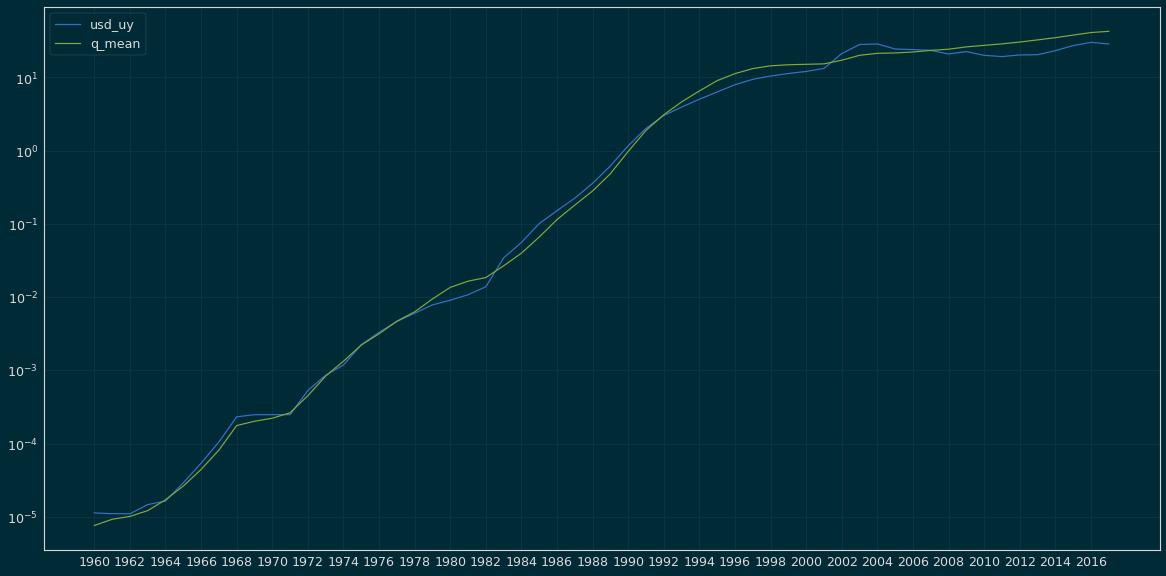

In [10]:
data[['usd_uy', 'q_mean']].plot(logy=True)
_ = plt.xticks(np.arange(data.index.min(), data.index.max(), 2))

That quotient is plotted just to see the effect, but it is not usable because it doesn't respect causality.

## Causal analysis

Let's first find if there is any significant difference by taking the mean of the quotients or performing least squares.

In [11]:
mean_coef

27.484474959655046

mean_coef = 27.484474959655046
a = 21.34813960810839, b = 0.5589049302476153


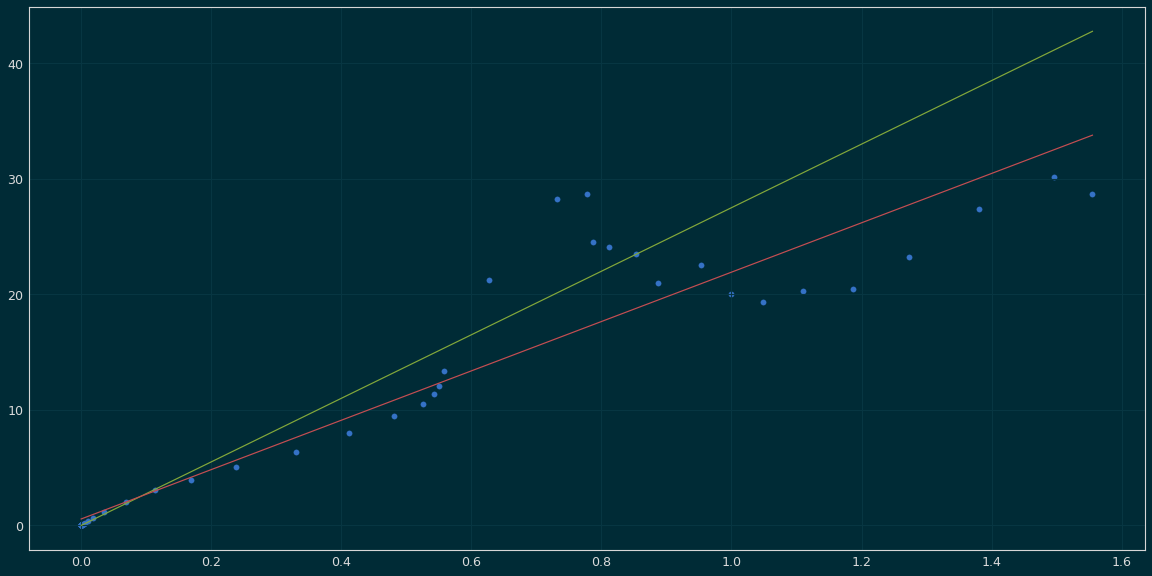

In [12]:
plt.scatter(data['raw_q'], data['usd_uy'])
xx = np.linspace(data['raw_q'].min(), data['raw_q'].max(), 100)
yy_mean = xx * mean_coef
plt.plot(xx, yy_mean, 'g')
p = np.polyfit(data['raw_q'], data['usd_uy'], 1)
yy_minsq = p[0] * xx + p[1]
plt.plot(xx, yy_minsq, 'r')
print('mean_coef = {}'.format(mean_coef))
print('a = {}, b = {}'.format(p[0], p[1]))

In [13]:
data[['raw_q', 'usd_uy']].head()

,raw_q,usd_uy
1960,2.765001e-07,0.000011
1961,3.358009e-07,0.000011
1962,3.680164e-07,0.000011
1963,4.407730e-07,0.000015
1964,6.196018e-07,0.000016


In [14]:
data['instant_mean_coef'] = data.usd_uy / data.raw_q
data['mean_coef'] = data.instant_mean_coef.expanding().mean()
data['causal_estimation'] = data.raw_q * data.mean_coef
data.head()

,cpi_uy,cpi_usa,usd_uy,raw_q,q_mean,instant_mean_coef,mean_coef,causal_estimation
1960,0.000004,13.563061,0.000011,2.765001e-07,0.000008,40.855916,40.855916,0.000011
1961,0.000005,13.708284,0.000011,3.358009e-07,0.000009,32.784808,36.820362,0.000012
1962,0.000005,13.872615,0.000011,3.680164e-07,0.000010,29.835627,34.492117,0.000013
1963,0.000006,14.044590,0.000015,4.407730e-07,0.000012,33.231388,34.176935,0.000015
1964,0.000009,14.224207,0.000016,6.196018e-07,0.000017,26.487440,32.639036,0.000020


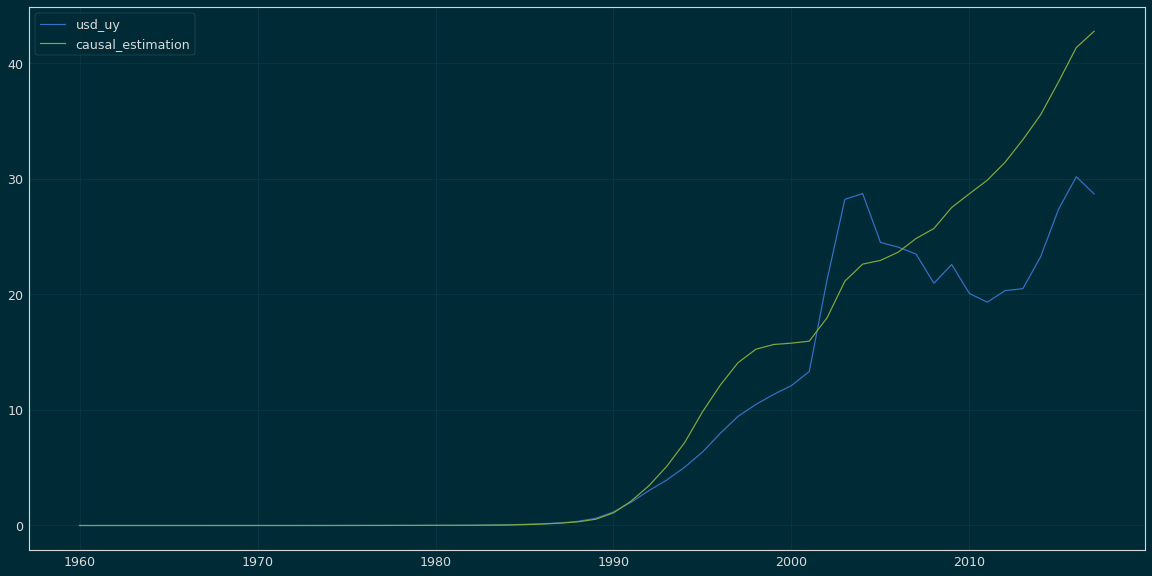

In [15]:
data[['usd_uy', 'causal_estimation']].plot()

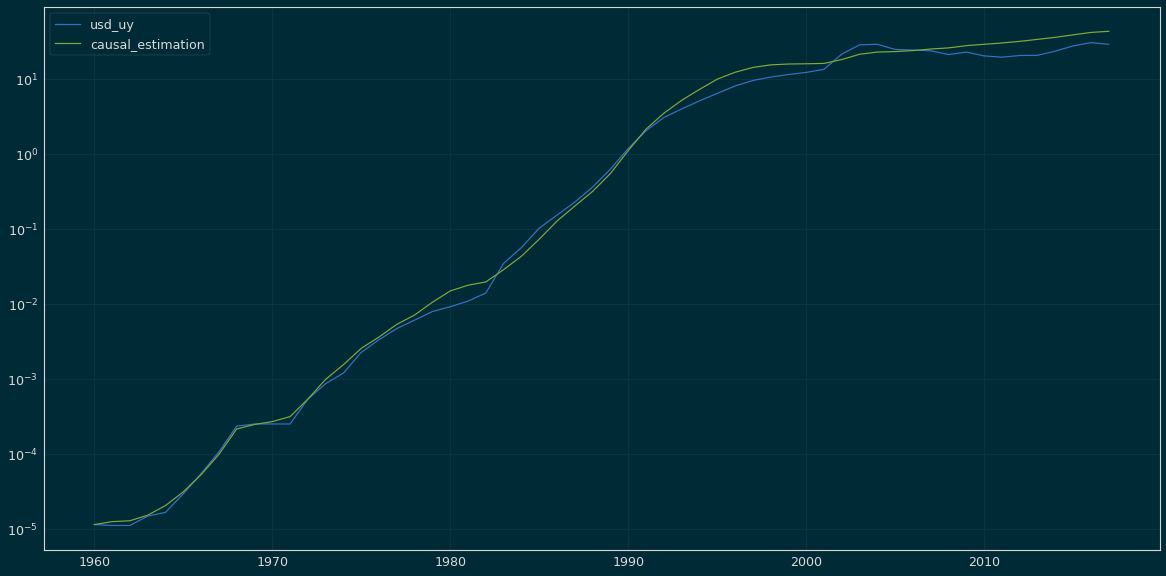

In [16]:
data[['usd_uy', 'causal_estimation']].plot(logy=True)

In [17]:
data['ewm_coef'] = data.instant_mean_coef.ewm(alpha=0.1).mean()
data['causal_estimation_ewm'] = data.raw_q * data.ewm_coef
data.head()

,cpi_uy,cpi_usa,usd_uy,raw_q,q_mean,instant_mean_coef,mean_coef,causal_estimation,ewm_coef,causal_estimation_ewm
1960,0.000004,13.563061,0.000011,2.765001e-07,0.000008,40.855916,40.855916,0.000011,40.855916,0.000011
1961,0.000005,13.708284,0.000011,3.358009e-07,0.000009,32.784808,36.820362,0.000012,36.607965,0.000012
1962,0.000005,13.872615,0.000011,3.680164e-07,0.000010,29.835627,34.492117,0.000013,34.108947,0.000013
1963,0.000006,14.044590,0.000015,4.407730e-07,0.000012,33.231388,34.176935,0.000015,33.853769,0.000015
1964,0.000009,14.224207,0.000016,6.196018e-07,0.000017,26.487440,32.639036,0.000020,32.054953,0.000020


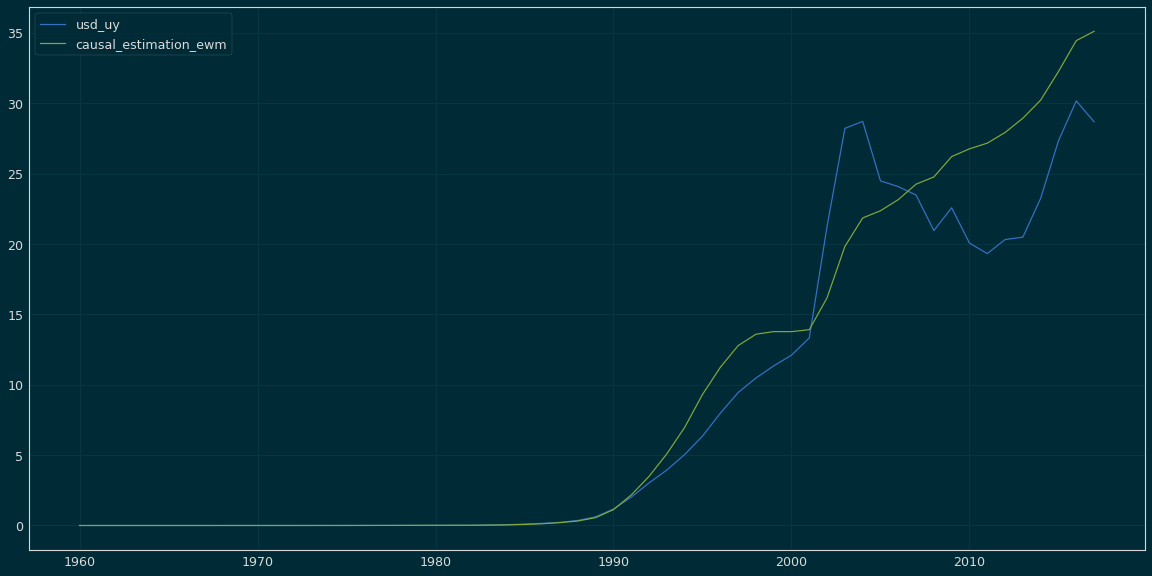

In [18]:
data[['usd_uy', 'causal_estimation_ewm']].plot()

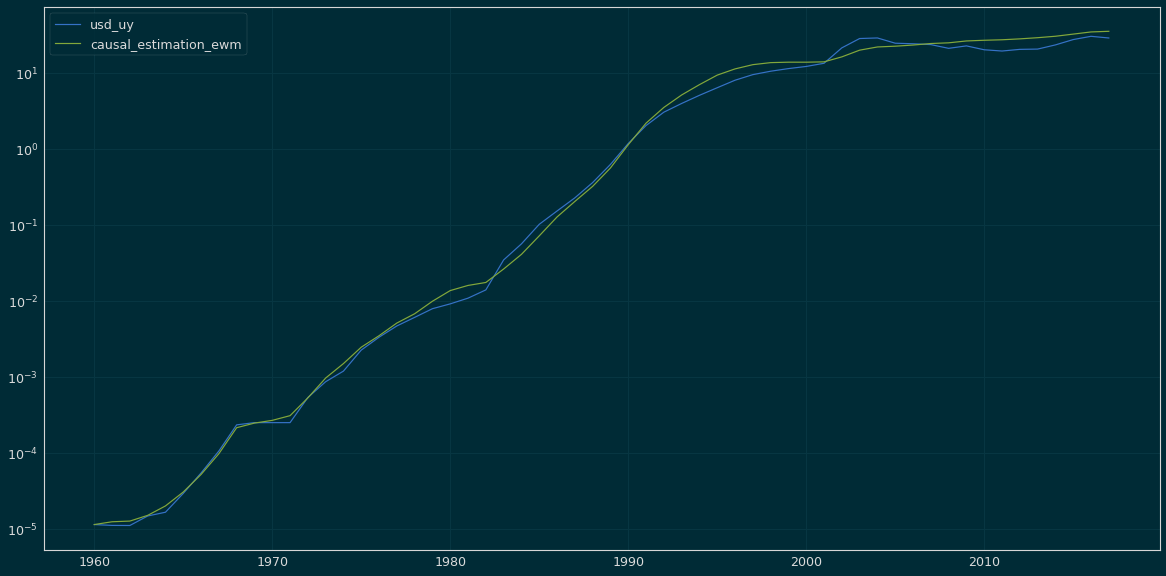

In [19]:
data[['usd_uy', 'causal_estimation_ewm']].plot(logy=True)

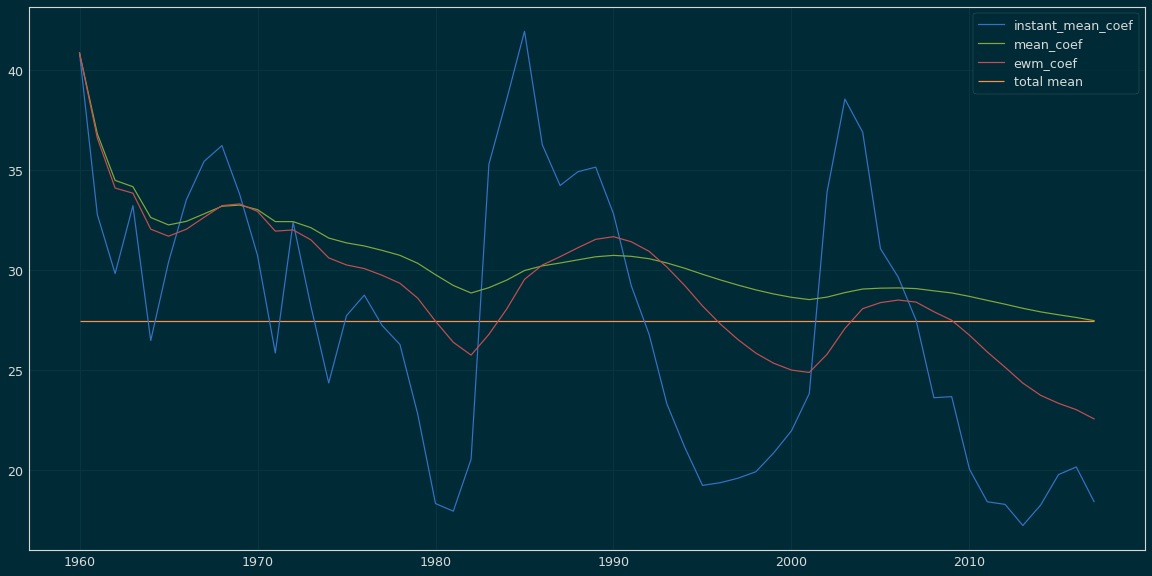

In [20]:
data[['instant_mean_coef', 'mean_coef', 'ewm_coef']].plot()
plt.hlines(mean_coef, data.index.min(), data.index.max(), 'y', label='total mean')
plt.legend()

I will use the expanding mean.

In [21]:
data['expanding_std_coef'] = data.instant_mean_coef.expanding().std()

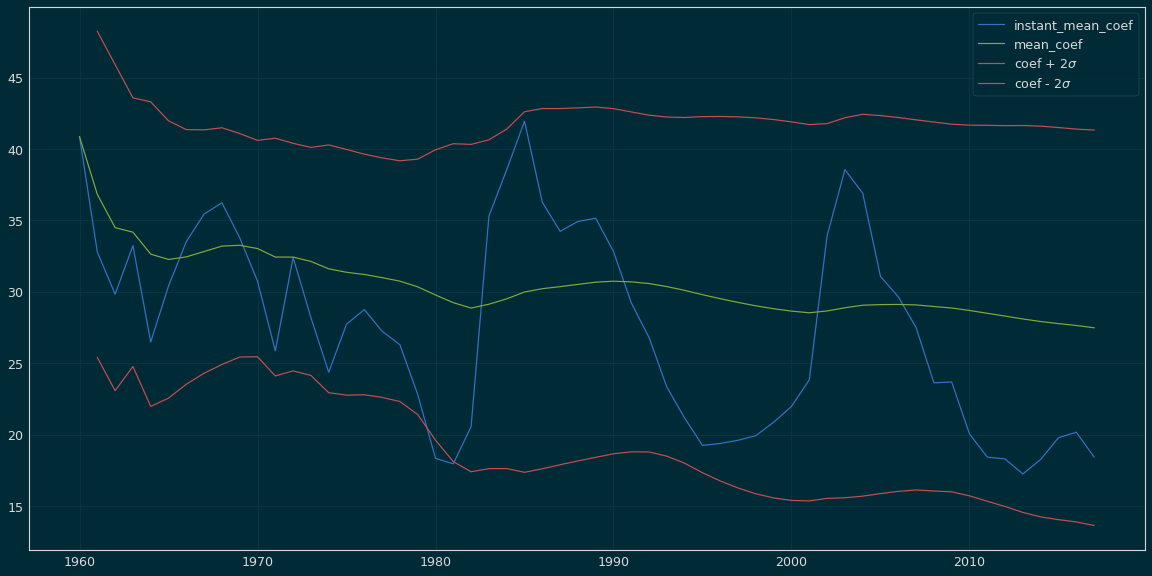

In [22]:
num_stds = 2
data[['instant_mean_coef', 'mean_coef']].plot()
plt.plot(data.index, data.mean_coef + num_stds * data.expanding_std_coef, 'r', 
         label='coef + {}$\sigma$'.format(num_stds))
plt.plot(data.index, data.mean_coef - num_stds * data.expanding_std_coef, 'r', 
         label='coef - {}$\sigma$'.format(num_stds))
plt.legend()

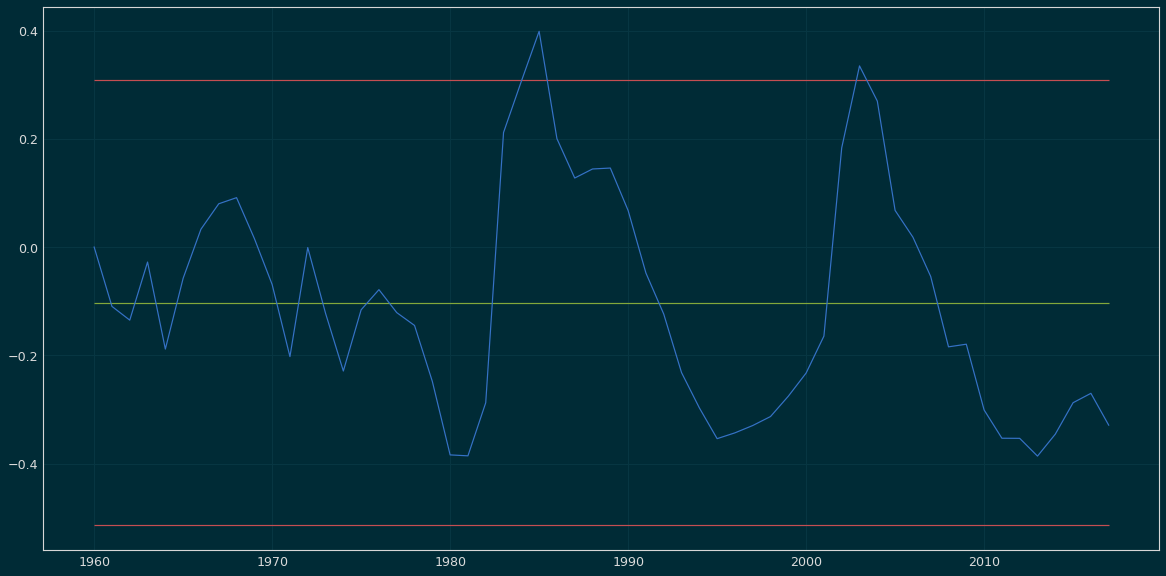

In [23]:
relative_e = (data.usd_uy - data.causal_estimation) / data.causal_estimation
relative_e.plot()
plt.hlines(relative_e.mean(), data.index.min(), data.index.max(), 'g')
plt.hlines(relative_e.mean() + 2 * relative_e.std(), data.index.min(), data.index.max(), 'r')
plt.hlines(relative_e.mean() - 2 * relative_e.std(), data.index.min(), data.index.max(), 'r')

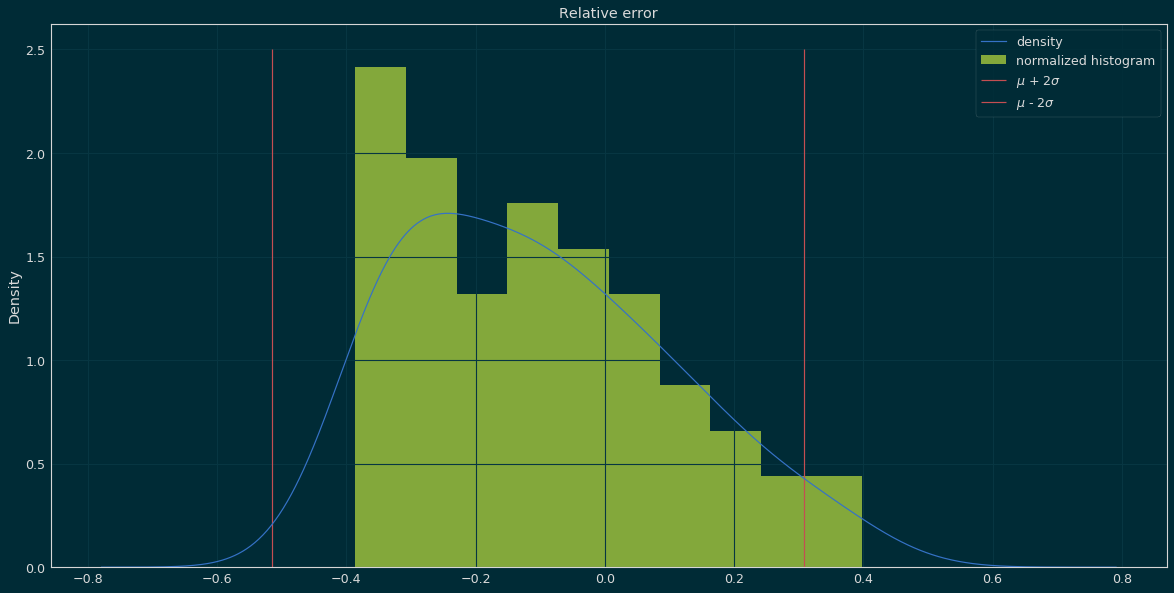

In [24]:
relative_e.plot(kind='density', label='density')
relative_e.hist(density=1, bins=10, label='normalized histogram')
plt.title('Relative error')
plt.vlines(relative_e.mean() + 2 * relative_e.std(), 0, 2.5, 'r', label='$\mu$ + 2$\sigma$')
plt.vlines(relative_e.mean() - 2 * relative_e.std(), 0, 2.5, 'r', label='$\mu$ - 2$\sigma$')
plt.legend()

In [25]:
data['max_causal_est'] = data.causal_estimation * (1 + 2 * relative_e.std())
data['min_causal_est'] = data.causal_estimation * (1 - 2 * relative_e.std())

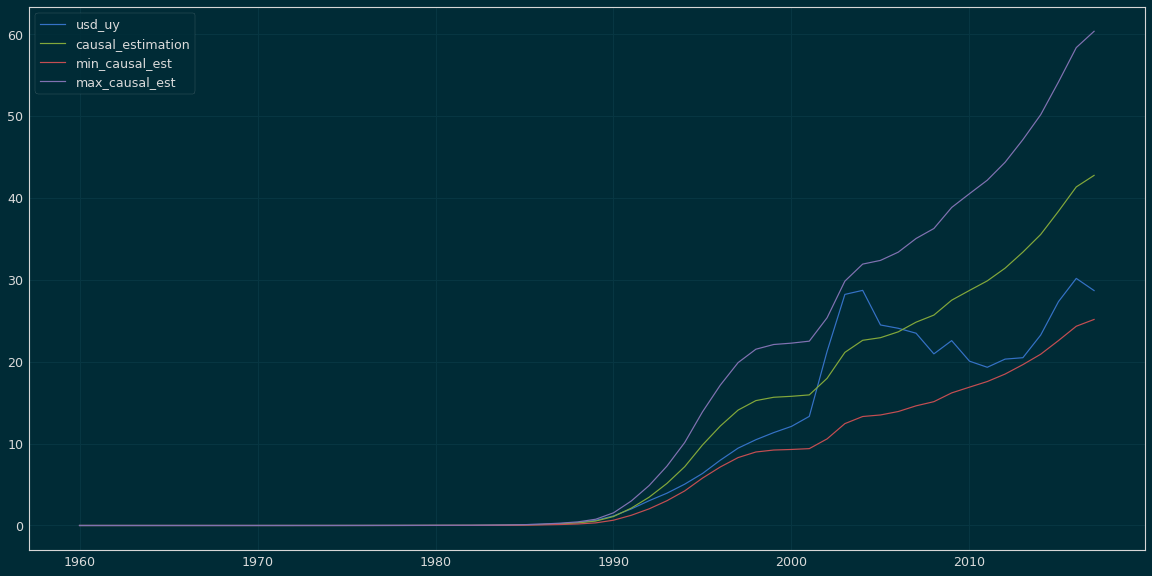

In [26]:
data[['usd_uy', 'causal_estimation', 'min_causal_est', 'max_causal_est']].plot()

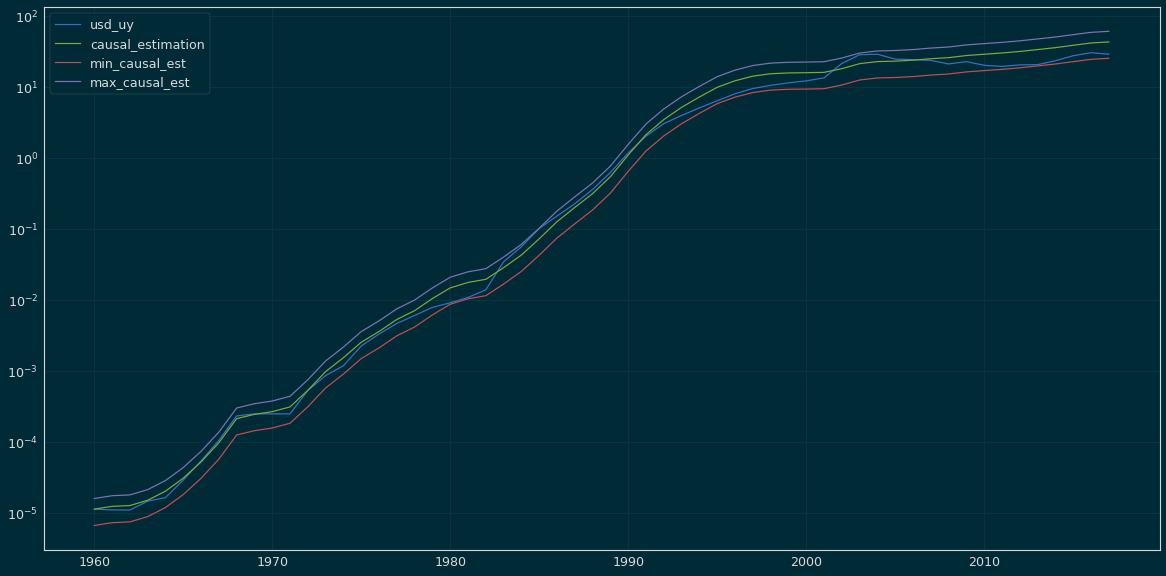

In [27]:
data[['usd_uy', 'causal_estimation', 'min_causal_est', 'max_causal_est']].plot(logy=True)

Let's use the expanding std instead of the total relative error, to mantain causality.

In [28]:
data.head()

,cpi_uy,cpi_usa,usd_uy,raw_q,q_mean,instant_mean_coef,mean_coef,causal_estimation,ewm_coef,causal_estimation_ewm,expanding_std_coef,max_causal_est,min_causal_est
1960,0.000004,13.563061,0.000011,2.765001e-07,0.000008,40.855916,40.855916,0.000011,40.855916,0.000011,NaN,0.000016,0.000007
1961,0.000005,13.708284,0.000011,3.358009e-07,0.000009,32.784808,36.820362,0.000012,36.607965,0.000012,5.707135,0.000017,0.000007
1962,0.000005,13.872615,0.000011,3.680164e-07,0.000010,29.835627,34.492117,0.000013,34.108947,0.000013,5.705074,0.000018,0.000007
1963,0.000006,14.044590,0.000015,4.407730e-07,0.000012,33.231388,34.176935,0.000015,33.853769,0.000015,4.700632,0.000021,0.000009
1964,0.000009,14.224207,0.000016,6.196018e-07,0.000017,26.487440,32.639036,0.000020,32.054953,0.000020,5.328942,0.000029,0.000012


In [29]:
data['relative_error'] = (data.usd_uy - data.causal_estimation) / data.causal_estimation
data['relative_error_std'] = data.relative_error.expanding().std()
data['relative_error_mean'] = data.relative_error.expanding().mean()
data['max_causal_est_2'] = data.causal_estimation * (
    1 + data.relative_error_mean + 2 * data.relative_error_std)
data['min_causal_est_2'] = data.causal_estimation * (
    1 + data.relative_error_mean - 2 * data.relative_error_std)

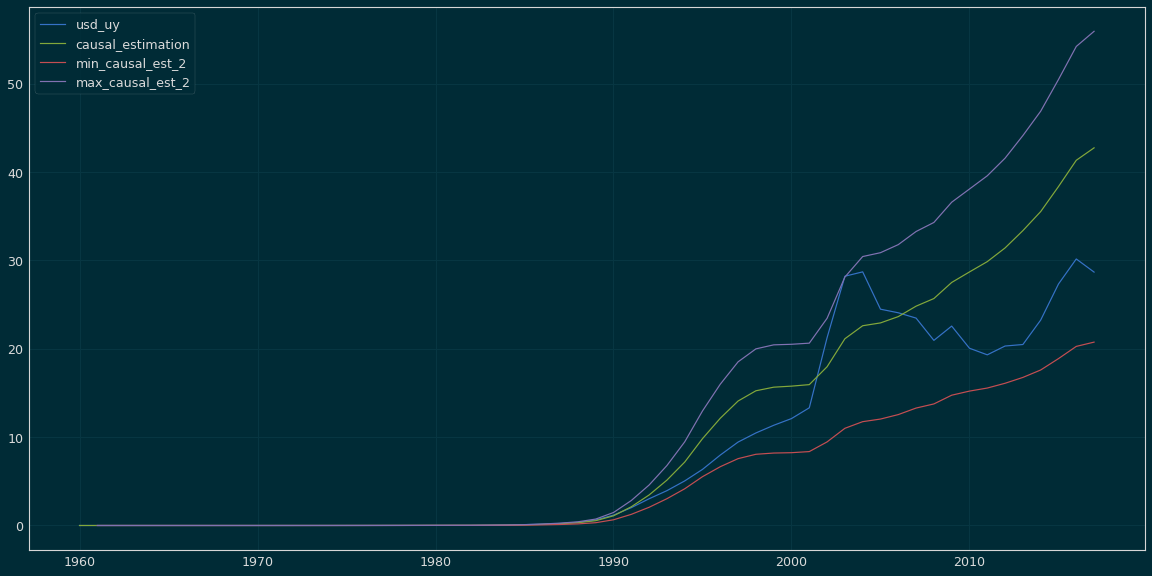

In [30]:
data[['usd_uy', 'causal_estimation', 'min_causal_est_2', 'max_causal_est_2']].plot()

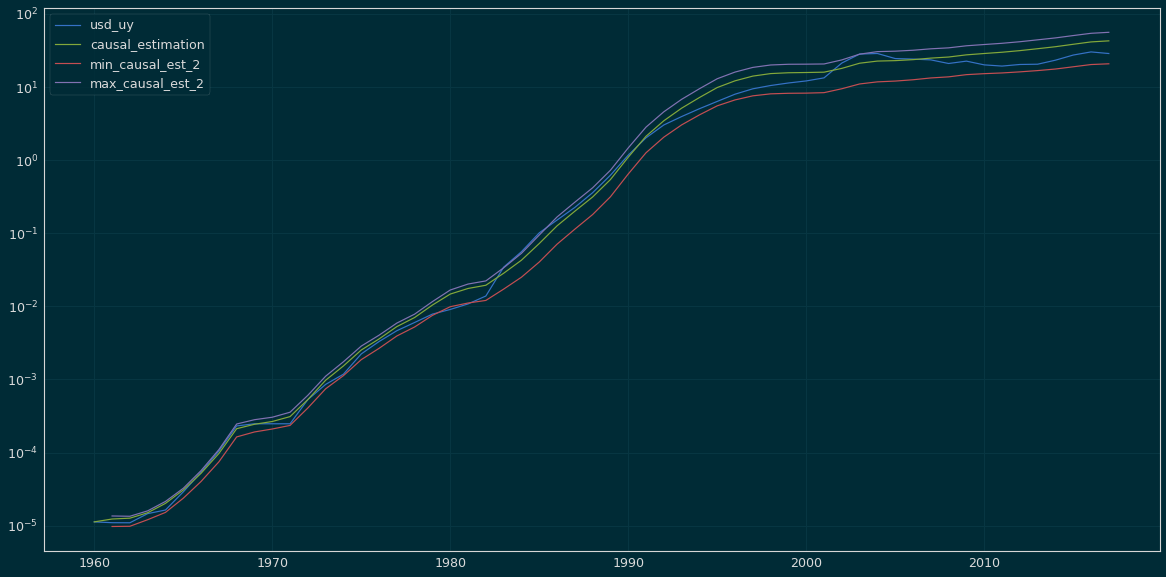

In [31]:
data[['usd_uy', 'causal_estimation', 'min_causal_est_2', 'max_causal_est_2']].plot(logy=True)

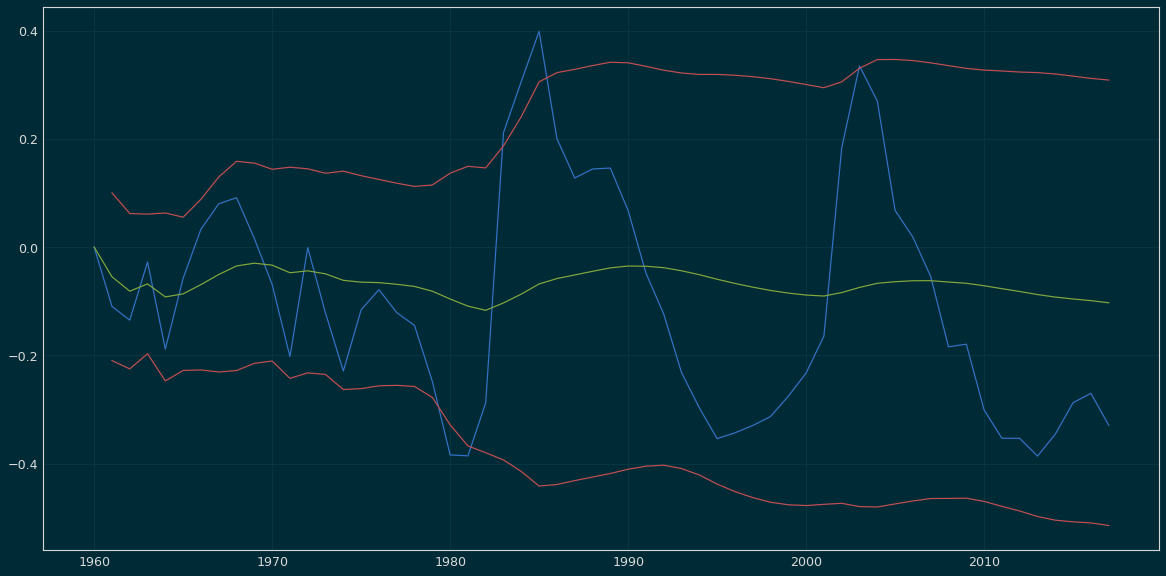

In [32]:
data.relative_error.plot()
data.relative_error_mean.plot(style='g')
(data.relative_error_mean + 2 * data.relative_error_std).plot(style='r')
(data.relative_error_mean - 2 * data.relative_error_std).plot(style='r')

## Cleanup

In [33]:
def causal_estimation(cpi, rate):
    """
    Calculate all the data to make a causal estimation of the exchange rate,
    according to the PPP theory: ex_rate_USD_UYU ~= a * CPI_uy / CPI_us
    The constant "a" is calculated with the expanding mean of the previous 
    values. The function makes no predictions into the future, only estimations
    of the theoretical value of the exchange rate in the present.
    
    Args:
        cpi(pd.DataFrame): The Consumer Price Index.
        rate(pd.DataFrame): The USD/UYU exchange rate.
    
    Returns:
        pd.DataFrame: All the needed data to plot the causal estimations.
    """
    data = cpi.join(rate.rename(columns={'Uruguay':'usd_uyu'}))
    data = data.rename(
        columns={'Uruguay': 'cpi_uy', 'United States': 'cpi_usa'})

    # Causal estimation
    data['raw_q'] = data.cpi_uy / data.cpi_usa
    data['instant_mean_coef'] = data.usd_uyu / data.raw_q
    data['mean_coef'] = data.instant_mean_coef.expanding().mean()
    data['causal_estimation'] = data.raw_q * data.mean_coef
    
    # Error estimation
    data['relative_error'] = (data.usd_uyu - data.causal_estimation) / data.causal_estimation
    data['relative_error_std'] = data.relative_error.expanding().std()
    data['relative_error_mean'] = data.relative_error.expanding().mean()
    data['relative_error_low'] = data.relative_error_mean - 2 * data.relative_error_std
    data['relative_error_high'] = data.relative_error_mean + 2 * data.relative_error_std
    data['causal_est_low'] = data.causal_estimation * (1 + data.relative_error_low)
    data['causal_est_high'] = data.causal_estimation * (1 + data.relative_error_high)
    
    return data

In [34]:
data = causal_estimation(cpi, rate)
data.head()

,cpi_uy,cpi_usa,usd_uyu,raw_q,instant_mean_coef,mean_coef,causal_estimation,relative_error,relative_error_std,relative_error_mean,relative_error_low,relative_error_high,causal_est_low,causal_est_high
1960,0.000004,13.563061,0.000011,2.765001e-07,40.855916,40.855916,0.000011,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN
1961,0.000005,13.708284,0.000011,3.358009e-07,32.784808,36.820362,0.000012,-0.109601,0.077500,-0.054801,-0.209800,0.100199,0.000010,0.000014
1962,0.000005,13.872615,0.000011,3.680164e-07,29.835627,34.492117,0.000013,-0.135002,0.071744,-0.081534,-0.225022,0.061953,0.000010,0.000013
1963,0.000006,14.044590,0.000015,4.407730e-07,33.231388,34.176935,0.000015,-0.027666,0.064474,-0.068067,-0.197015,0.060881,0.000012,0.000016
1964,0.000009,14.224207,0.000016,6.196018e-07,26.487440,32.639036,0.000020,-0.188474,0.077571,-0.092149,-0.247290,0.062993,0.000015,0.000021


In [35]:
def basic_plots(data):
    plt.figure()
    ax = plt.subplot(1, 2, 1)
    data[['usd_uyu', 
          'causal_estimation', 
          'causal_est_low',
          'causal_est_high']].plot(ax=ax)
    ax = plt.subplot(1, 2, 2)
    data[['usd_uyu', 
          'causal_estimation', 
          'causal_est_low',
          'causal_est_high']].plot(logy=True, ax=ax)
    plt.figure()
    plt.subplot(1, 2, 1)
    data.relative_error.plot()
    data.relative_error_mean.plot(style='g')
    data.relative_error_low.plot(style='r')
    data.relative_error_high.plot(style='r')
    plt.legend()
    plt.title('Relative error trace')
    plt.subplot(1, 2, 2)
    data.relative_error.plot(kind='density', label='density')
    data.relative_error.hist(density=1, bins=10, label='normalized histogram')
    plt.vlines(data.relative_error.iloc[-1], 0, 2.5, colors='r', label='Current value')
    plt.legend()
    plt.title('Relative error histogram and density')

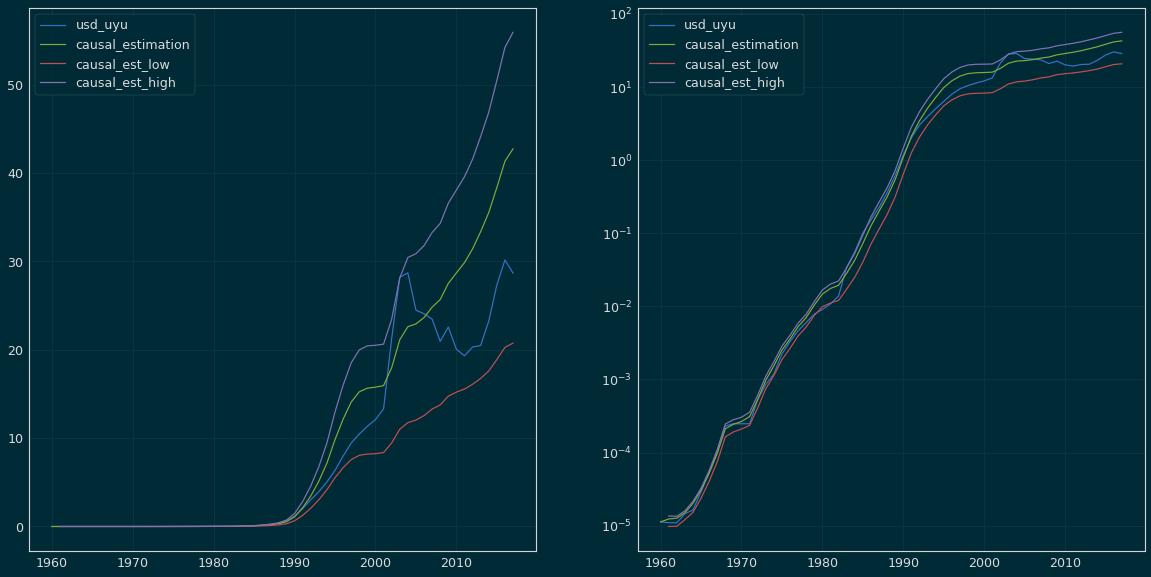

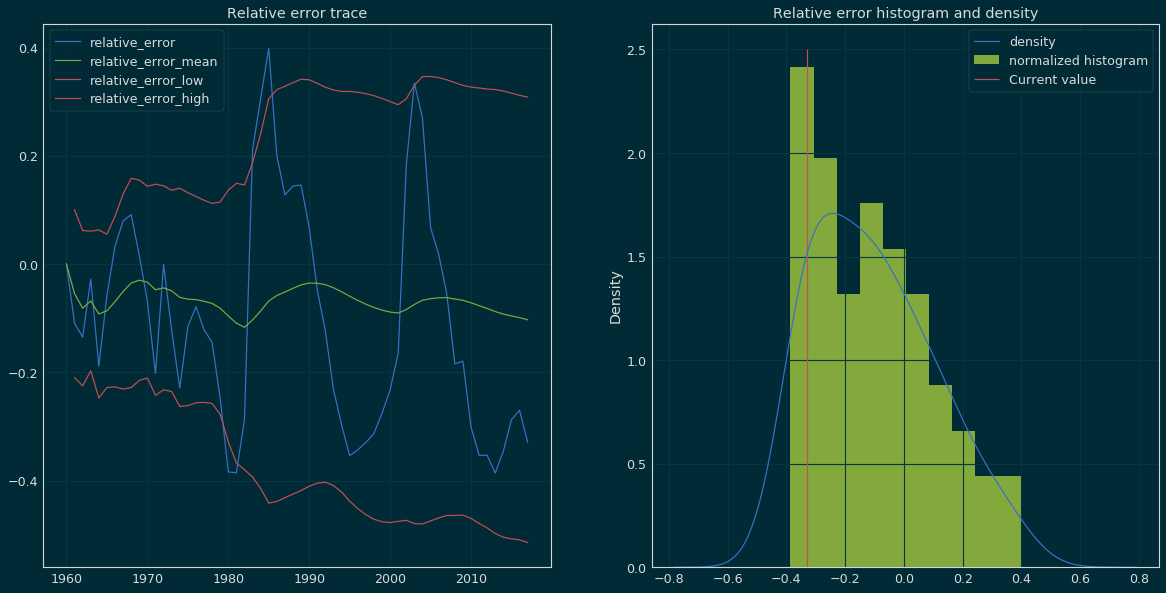

In [36]:
basic_plots(data)

In [37]:
from scipy.stats import percentileofscore

In [38]:
percentileofscore(data.relative_error, data.relative_error.iloc[-1])

/home/miguel/anaconda3/envs/data/lib/python3.6/site-packages/scipy/stats/stats.py:1719: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pct = (np.mean(a_len[idx]) / n) * 100.0


17.24137931034483

In [39]:
import datetime as dt

In [40]:
dt.datetime.now().year

2018

In [44]:
import plotly.plotly as py
import plotly.figure_factory as ff
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

import numpy as np

x = np.random.randn(1000)  
hist_data = [x]
group_labels = ['distplot']

fig = ff.create_distplot(hist_data, group_labels)
init_notebook_mode(connected=True)

_ = iplot(fig, filename='Basic Distplot.html')